## Ordinary Differential Equations (ODEs)

In [2]:
# Import numpy and matplotlib, and use jupyter magic to
# get plots directly in notebook
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
# Get nicer looking plots than default
plt.style.use('bmh')
# Timer to measure the performance of methods
from time import time
from scipy.integrate import odeint

Runge-Kutta, steps:  826 time:  0.5280508995056152
Forward Euler, steps:  51250 time:  6.73876690864563


/Users/nordam/.virtualenvs/default/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


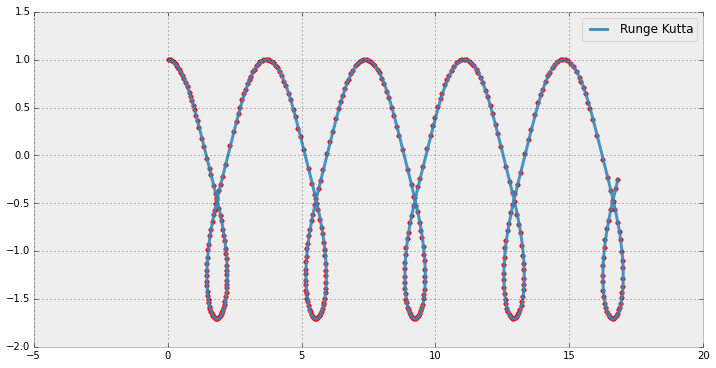

In [42]:
## Example problem:
# Particle trajectory in variable magnetic field

def B(t, x):
    return x[1]**2*np.array([0., 0., 1.])

def f(t, y, z):
    return z

def g(t, y, z):
    q = 1
    m = 1
    return q*np.cross(z, B(t, y))/m

def forwardEuler(h, t, y, z, f, g):
    k1 = f(t, y, z)
    l1 = g(t, y, z)
    y_new = y + h*k1
    z_new = z + h*l1
    return y_new, z_new

def rungeKutta(h, t, y, z, f, g):
    k1 = f(t, y, z)
    l1 = g(t, y, z)
    k2 = f(t + h/2, y+h*k1/2, z+h*l1/2)
    l2 = g(t + h/2, y+h*k1/2, z+h*l1/2)
    k3 = f(t + h/2, y+h*k2/2, z+h*l2/2)
    l3 = g(t + h/2, y+h*k2/2, z+h*l2/2)
    k4 = f(t + h,   y+h*k3,   z+h*l3)
    l4 = g(t + h,   y+h*k3,   z+h*l3)
    y_new = y + h*(k1 + 2*k2 + 2*k3 + k4)/6
    z_new = z + h*(l1 + 2*l2 + 2*l3 + l4)/6
    return y_new, z_new

def stepper(h, t, x, v, f, g, integrator):
    # Step once, with stepsize h
    x1, v1 = integrator(h, t, x, v, f, g)
    # Step twice, with stepsize h/2
    x2, v2 = integrator(h/2, t, x, v, f, g)
    x2, v2 = integrator(h/2, t, x2, v2, f, g)
    # calculate error
    
    err = np.linalg.norm(x2-x1)/np.linalg.norm(x2)
    # Return x2, v2, which are presumably more accurate
    return x2, v2, err

def variableIntegrate(Tmax, h0, tol, integrator):
    T  = []
    X  = []
    V  = []
    # Initial values
    x  = np.array([0., 1., 0.])
    v  = np.array([1., 0., 0.])
    # Mapping to new variables, y and z:
    # y = x
    # z = v
    
    # Start at time 0, with initial guess of stepsize
    t = 0
    h = h0
    while t < Tmax:
        T.append(t)
        flag = True
        while flag:
            x1, v1, err = stepper(h, t, x, v, f, g, integrator)
            if err > tol:
                h = h/2
            else:
                t += h
                h = 1.5*h
                x = x1
                v = v1
                flag = False
        X.append(x)
        V.append(v)
    T = np.array(T)
    X = np.array(X)
    V = np.array(V)
    return T, X, V
    
Tmax = 12*np.pi
h0   = 5e-1
tol  = 1e-7

# Figure parameters
plt.figure(figsize = (12,6))
linewidth = 3
alpha = 0.9

tic = time()
Tr, Xr, Vr = variableIntegrate(Tmax, h0, tol, rungeKutta)
toc = time()
print('Runge-Kutta, steps: ', 2*len(Tr), 'time: ', toc - tic)
plt.plot(Xr[:,0], Xr[:,1], label = 'Runge Kutta', lw = linewidth, alpha = alpha)
plt.scatter(Xr[:,0], Xr[:,1], marker = 'o', s = 20, color = 'r')

tic = time()
Te, Xe, Ve = variableIntegrate(Tmax, h0, tol, forwardEuler)
toc = time()
print('Forward Euler, steps: ', 2*len(Te), 'time: ', toc - tic)
#plt.plot(Xe[:,0], Xe[:,1], label = 'Forward Euler', lw = linewidth, alpha = alpha)
#plt.scatter(Xe[:,0], Xe[:,1], marker = 'o', s = 20, color = 'r')

plt.legend(loc = 'best')

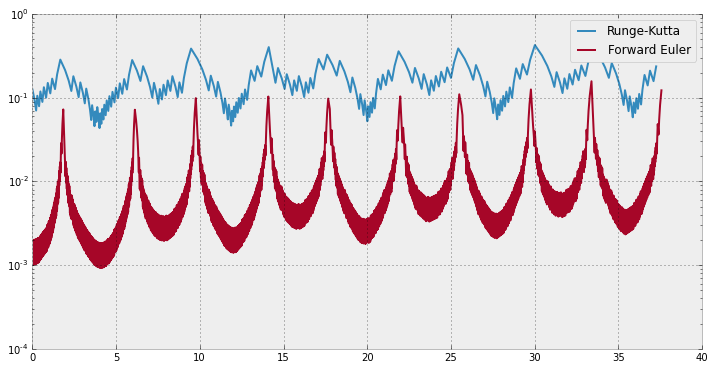

In [39]:
# Visualise timesteps

fig, ax = plt.subplots(1, figsize = (12, 6))
for i, (V, T, label) in enumerate([(Vr, Tr, 'Runge-Kutta'), (Ve, Te, 'Forward Euler')]):
    ax.plot(T[:-1], T[1:]-T[:-1], label = label)
ax.legend()
ax.set_yscale('log')

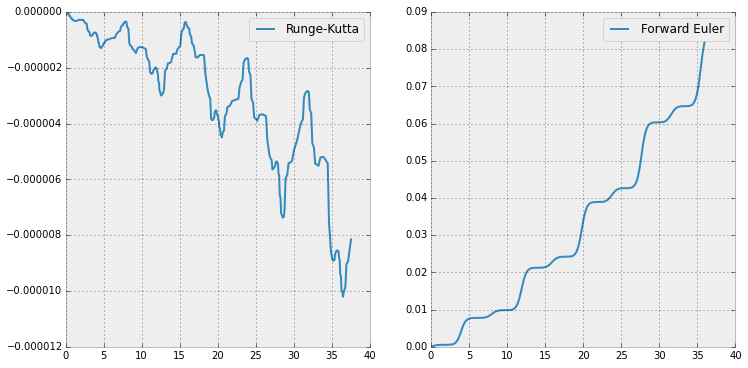

In [40]:
# Check conservation of energy
# Plot Ek(t)/Ek(t=0) - 1

def Ek(V):
    return 0.5*(V[:,0]**2+V[:,1]**2+V[:,2]**2)

Ek0 = 0.5

fig, ax = plt.subplots(1, 2, figsize = (12, 6))
for i, (V, T, label) in enumerate([(Vr, Tr, 'Runge-Kutta'), (Ve, Te, 'Forward Euler')]):
    ax[i].plot(T, Ek(V)/Ek0-1, label = label)
    ax[i].legend()

/Users/nordam/.virtualenvs/default/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


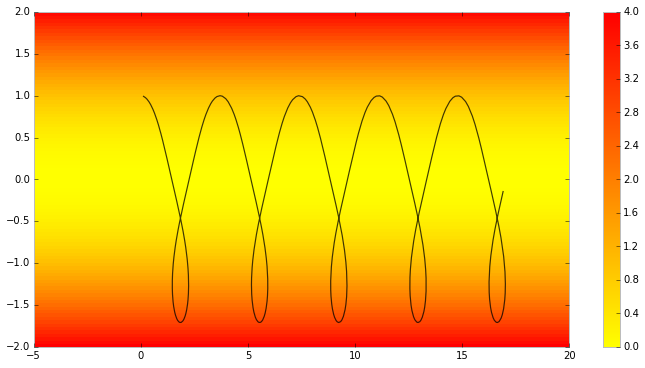

In [41]:
# Visualise magnetic field used above

def B(x, y):
    return y**2
    
X = np.linspace(-5, 20, 200)
Y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(X, Y)
# Figure parameters
plt.figure(figsize = (12,6))
mesh = plt.pcolormesh(X, Y, B(X, Y), cmap = plt.get_cmap('autumn_r'))
plt.plot(Xr[:,0], Xr[:,1], label = 'Runge Kutta', c = 'k', lw = 1.2, alpha = 0.75)
plt.colorbar(mesh)